<a href="https://colab.research.google.com/github/Ruchit13/Dogs-vs-Cats-CNN/blob/master/Dogs_vs_Cats_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sherlockey","key":"ad80ffc0e96fe7622179dd141acee3a0"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle competitions download -c dogs-vs-cats

In [ ]:
! mkdir train
! unzip train.zip -d train

In [ ]:
! mkdir test
! unzip test1.zip -d test

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [ ]:
img_width = 128
img_height = 128
img_size = (img_height,img_width)
img_channels = 3

In [ ]:
import os

In [ ]:
filenames = os.listdir('/content/train/train')

categories = []
for f_name in filenames:
  category = f_name.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

dataframe = pd.DataFrame({'filename': filenames , 'category': categories})

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,BatchNormalization,Activation,MaxPool2D,Flatten,Dense

model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape = (img_height,img_width,img_channels)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer = 'rmsprop', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)       

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
dataframe['category'] = dataframe['category'].replace({0:'cat',1:'dog'})

train_df, validation_df = train_test_split(dataframe,test_size = 0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop = True)

total_train = train_df.shape[0]
total_validate = validation_df.shape[0]
batch_size = 15

In [ ]:
test_filenames = os.listdir("/content/test/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255, shear_range=0.1,
                                zoom_range=0.2, horizontal_flip=True,
                                width_shift_range=0.1, height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,'/content/train/train',
                                                    x_col = 'filename',y_col = 'category',
                                                    target_size = img_size, class_mode = 'categorical',
                                                    batch_size = batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(validation_df,'/content/train/train',
                                                    x_col = 'filename',y_col = 'category',
                                                    target_size = img_size, class_mode = 'categorical',
                                                    batch_size = batch_size)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)


test_generator = test_datagen.flow_from_dataframe(test_df,'/content/test/test1',
                                                 target_size=img_size,class_mode=None,
                                                batch_size=batch_size)

###test_generator = test_datagen.flow_from_directory(
    #directory='/content/test/test1',
    #target_size=(128, 128),
   # color_mode="rgb",
  #  class_mode=None,
 #   shuffle=False
#)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [ ]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 177s 133ms/step - loss: 0.5210 - accuracy: 0.7434 - val_loss: 0.4506 - val_accuracy: 0.7992
Epoch 2/10
1333/1333 [==============================] - 177s 133ms/step - loss: 0.4760 - accuracy: 0.7773 - val_loss: 0.5383 - val_accuracy: 0.7257
Epoch 3/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.7965
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 177s 133ms/step - loss: 0.4421 - accuracy: 0.7965 - val_loss: 0.5564 - val_accuracy: 0.7489
Epoch 4/10
1333/1333 [==============================] - 177s 133ms/step - loss: 0.3924 - accuracy: 0.8240 - val_loss: 0.3424 - val_accuracy: 0.8579
Epoch 5/10
1333/1333 [==============================] - 176s 132ms/step - loss: 0.3719 - accuracy: 0.8343 - val_loss: 0.6212 - val_accuracy: 0.7960
Epoch 6/10
1333/1333 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.

In [ ]:
predict = model.predict_generator(test_generator,
                                  steps= np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

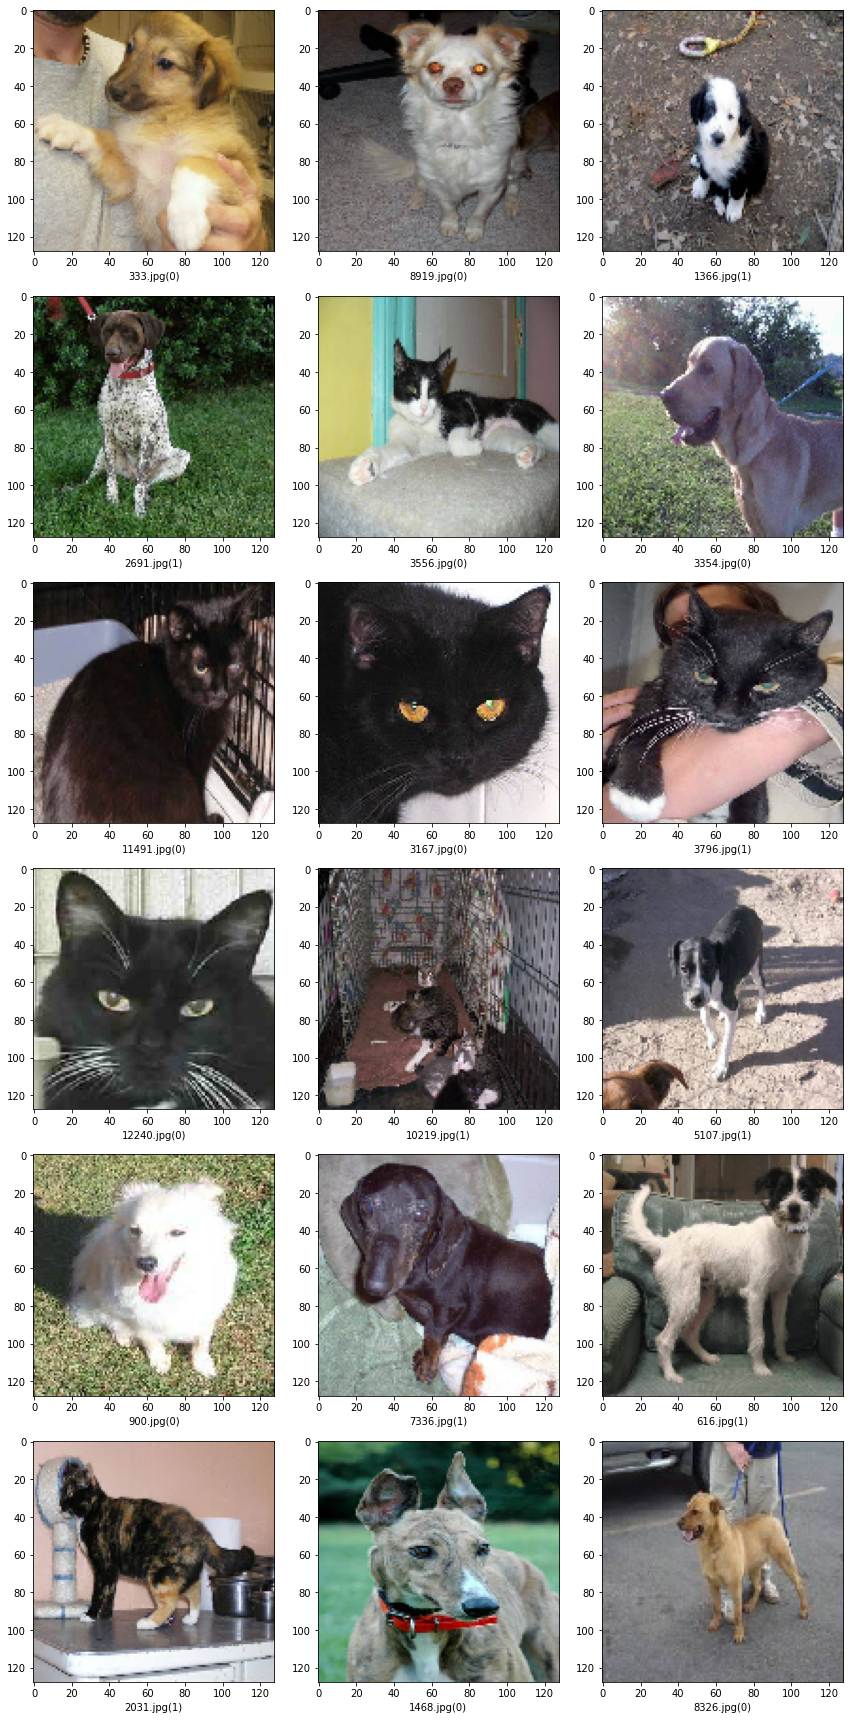

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test/test1/"+filename, target_size=img_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("")
im=im.resize(img_size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])